In [3]:
#%pip install lyricsgenius

In [4]:
import lyricsgenius as lg
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
FOLDER = "data/"

## Data wrangling:
The final data frame **top10\_df** contains top 10 songs per year, sorted by **'Weeks on Chart'**, i.e. the number of weeks they've been on the Billboard chart.

In [6]:
filename = 'billboard.csv'
df = pd.read_csv(FOLDER+filename)
df['Year'] = pd.to_datetime(df['WeekID']).dt.year
df = df.rename(columns={"Week Position":"WeekPosition"})
df = df.drop_duplicates(['SongID'])
df.head()

,url,WeekID,WeekPosition,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,Year
0,http://www.billboard.com/charts/hot-100/1963-0...,6/1/1963,11,Still,Bill Anderson,StillBill Anderson,1.0,17.0,11.0,8.0,1963
1,http://www.billboard.com/charts/hot-100/1967-0...,1/7/1967,11,Coming Home Soldier,Bobby Vinton,Coming Home SoldierBobby Vinton,1.0,17.0,11.0,8.0,1967
2,http://www.billboard.com/charts/hot-100/1971-0...,7/3/1971,11,She's Not Just Another Woman,The 8th Day,She's Not Just Another WomanThe 8th Day,1.0,17.0,11.0,8.0,1971
3,http://www.billboard.com/charts/hot-100/1975-1...,11/29/1975,11,Saturday Night,Bay City Rollers,Saturday NightBay City Rollers,1.0,17.0,11.0,8.0,1975
4,http://www.billboard.com/charts/hot-100/1979-0...,9/29/1979,11,Pop Muzik,M,Pop MuzikM,1.0,17.0,11.0,8.0,1979


In [7]:
df = df.sort_values(by='Weeks on Chart', ascending=False)
top10_df = df.groupby('Year').head(10)
top10_df = top10_df[['Song', 'Performer', 'Year']]
top10_df['Decade'] = (top10_df['Year']//10)*10
top10_df.head()

,Song,Performer,Year,Decade
167831,Eastside,"benny blanco, Halsey & Khalid",2019,2010
252653,Wait For You,Elliott Yamin,2007,2000
271215,Wildflower,Skylark,1973,1970
177187,Even Though I'm Leaving,Luke Combs,2019,2010
315541,Do Re Mi,blackbear,2017,2010


In [8]:
print("Total number of songs: ",len(top10_df))

Total number of songs:  630


(array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([1958.        , 1958.98412698, 1959.96825397, 1960.95238095,
        1961.93650794, 1962.92063492, 1963.9047619 , 1964.88888889,
        1965.87301587, 1966.85714286, 1967.84126984, 1968.82539683,
        1969.80952381, 1970.79365079, 1971.77777778, 1972.76190476,
        1973.74603175, 1974.73015873, 1975.71428571, 1976.6984127 ,
        1977.68253968, 1978.66666667, 1979.65079365, 1980.63492063,
        1981.61904762, 1982.6031746 , 1983.58730159, 1984.57142857,
        1985.55555556, 1986.53968254, 1987.52380952, 1988.50793651,
        1989.49206349, 1990.47619048, 1991.46031746, 1992.44444444,
        1993.42857143, 1994.412

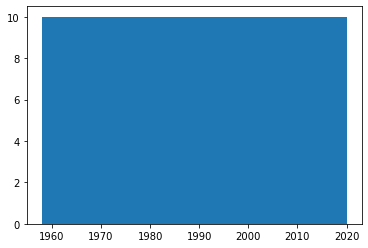

In [9]:
plt.hist(x=top10_df.Year, bins= 63)

## Lyrics scraping:
We get the lyrics for the top_10 songs from Genius API.

We notice that some songs list 2 names of performers, some other list 2 titles (title1/title2), which leads to various errors in the scraping of the lyrics from Genius. So we make some updates:

In [10]:
def update_performer(performer):
    try:
        if performer.find("duet with") > 0:
            performer = performer.split("duet with", 1)[0] #take the performer_1 in "performer_1 duet with performer_2"
        elif performer.find("with") > 0:
            performer = performer.split("with", 1)[0] #take the performer_1 in "performer_1 with performer_2"
        elif performer.find(" and") > 0:
            performer = performer.split(" and", 1)[0]
        elif performer.find("&") > 0:
            performer = performer.split("&", 1)[0]
        elif performer.find("featuring") > 0:
            performer = performer.split("featuring", 1)[0]
        elif performer.find("feat") > 0:
            performer = performer.split("feat", 1)[0]
    except:
        print("Error:", performer)
        
    return performer

In [11]:
top10_df['Performer'] = top10_df['Performer'].str.lower()

top10_df['Performer'] = top10_df.apply(lambda x: update_performer(x['Performer']), axis=1)

In [12]:
def update_song(title):
    try:
        if title.find("/") > 0:
            title = title.split("/", 1)[0] #take the title_1 in "title_1/title_2"
        elif title.find("(from") > 0:
            title = title.split("(from", 1)[0]
    except:
        print("Error:", title)
        
    return title

In [13]:
top10_df['Song'] = top10_df['Song'].str.lower()

top10_df['Song'] = top10_df.apply(lambda x: update_song(x['Song']), axis=1)

We save the lyrics of each song in a column **Lyrics**.

In [14]:
token = 'vLxzP-1gpCyF2ZwDa_Sfjk1gm9WlA7yVVgRFFpRO6wyIH72DA8sOEynW7jj1aYKh'

genius = lg.Genius(token, 
                   skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], 
                   remove_section_headers=True) #ignore metadata

In [15]:
"""
@params: a song title and the performer's name
@return: the lyrics, or "Error" in case of exception
"""
def get_lyrics(song, performer):
    try:
        return genius.search_song(song, performer).lyrics
    except: 
        return "Error"

In [ ]:
top10_df['Lyrics'] = top10_df.apply(lambda x: get_lyrics(x['Song'],x['Performer']), axis=1)

Searching for "eastside" by benny blanco, halsey ...
Done.
Searching for "wait for you" by elliott yamin...
Done.
Searching for "wildflower" by skylark...
Done.
Searching for "even though i'm leaving" by luke combs...
Done.
Searching for "do re mi" by blackbear...
Done.
Searching for "you make it easy" by jason aldean...
Done.
Searching for "smack that" by akon ...
Done.
Searching for "alley-oop" by hollywood argyles...
Done.
Searching for "quiet village" by the exotic sounds of martin denny...
Done.
Searching for "the ballad of the green berets" by ssgt barry sadler...
Done.
Searching for "run this town" by jay-z, rihanna ...
Done.
Searching for "poor side of town" by johnny rivers...
Done.
Searching for "blue moon" by the marcels...
Done.
Searching for "burning bridges" by jack scott...
Done.
Searching for "take a bow" by rihanna...
Done.
Searching for "classical gas" by mason williams...
Specified song does not contain lyrics. Rejecting.
Searching for "suspicion" by terry stafford..

In [ ]:
top10_df.query('Lyrics=="Error"')

In [ ]:
print("Total number of errors: ", len(top10_df.query('Lyrics=="Error"')))

The number of erronous lyrics is low, we can simply drop them.

In [ ]:
top10_df = top10_df.drop(top10_df[top10_df.Lyrics=="Error"].index)

We save the final dataframe to a csv file.

In [ ]:
filename = "lyrics_per_song.csv"
out_file = open(FOLDER+filename, "w")

top10_df.to_csv(out_file, index=False)

We write the lyrics of the songs in separate files by decade.
<br> Also append the lyrics to the file "all_lyrics" each time.

In [ ]:
filename = "all_lyrics.txt"
all_file = open(FOLDER+filename, 'w')

In [ ]:
for dec in top10_df.Decade.unique():
    filename = "%s_lyrics.txt" % dec
    file = open(FOLDER+filename, 'w')
    _df = top10_df.query("Decade == @dec")
    for l in _df.Lyrics:
        file.write(l)
        all_file.write(l)

# ---------------------------------------------------------------------------------------------------
<br> We notice wrong results of Genius queries. Here are some examples:

In [ ]:
top10_df[top10_df['Lyrics'].str.contains("What parallel courses did Bloom and Stephen follow returning?")]

This is the text written in file 1950_lyrics.txt:

In [ ]:
song = "quiet village"
performer = "the exotic sounds of martin denny"
genius.search_song(song, performer).lyrics

Whereas the correct lyrics should be the following (small) text:

In [ ]:
song = "quiet village"
performer = "martin denny"
genius.search_song(song, performer).lyrics

However we cannot fix such errors automatically, and it's not a good idea to do it manually because we can't know how many of them exist.

In [ ]:
top10_df[top10_df['Lyrics'].str.contains("In the 1960’s, politics and music had a close relationship.")]

In [ ]:
song = "the ballad of the green berets"
performer = "barry sadler"
genius.search_song(song, performer).lyrics

In [ ]:
top10_df[top10_df['Lyrics'].str.contains('Andrew Huang, "Summertime Feeling"')]

In [ ]:
song = "abracadabra"
performer = "the steve miller b"
genius.search_song(song, performer).lyrics

In [ ]:
song = "Abracadabra"
performer = "Steve Miller Band"
genius.search_song(song, performer).lyrics

In [ ]:
#the below ones seem to not exist in Genius ! 

In [ ]:
top10_df[top10_df['Lyrics'].str.contains('Chapter 1vandalizing the standards we are held to')]

In [ ]:
top10_df[top10_df['Lyrics'].str.contains('I am actually totally shocked. What the hell?')]